In [1]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import joblib
from keras.models import load_model
import tensorflow as tf
import keras
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

np.random.seed(10)
nuc_d = {'a': [1, 0, 0, 0], 'c': [0, 1, 0, 0], 'g': [0, 0, 1, 0], 't': [0, 0, 0, 1] }
nucs = "acgt"

In [2]:
def vectorizeSequence(seq):

    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    return np.array([ltrdict[x] for x in seq])

## Genetic algorithm
def ret_rand_nuc():
    x = random.randint(0, 3)
    if x == 0:
        return [1, 0, 0, 0]  # A
    if x == 1:
        return [0, 1, 0, 0]  # C
    if x == 2:
        return [0, 0, 1, 0]  # G
    if x == 3:
        return [0, 0, 0, 1]  # T

def vector_to_nuc(arr, seq_len=50):
    seq = ''
    for i in range(seq_len):
        if arr[i, 0] == 1:
            seq = seq + 'A'
        if arr[i, 1] == 1:
            seq = seq + 'C'
        if arr[i, 2] == 1:
            seq = seq + 'G'
        if arr[i, 3] == 1:
            seq = seq + 'T'
    return seq

def convert_and_save(sequences, predictions):
    # Convert the one-hot encoded sequences to A, C, T, G
    seqs = []
    for nbr in range(len(sequences)):
        seqs.append(vector_to_nuc(sequences[nbr]))
    df = pd.DataFrame(data=[seqs, predictions.tolist()]).transpose()
    df.columns = ['utr', 'prediction']
    df.sort_values('prediction', ascending=False, inplace=True)
    return df

def make_random_sequences(nbr_sequences, length, constant='', no_uaug=False, no_stop=False):
    # Make randomized sequences, allowing for the inclusion / exclusion of uATGs / stop codons
    seqs = []
    nucs = {0: 'A', 1: 'T', 2: 'C', 3: 'G'}
    i = 0
    while i < nbr_sequences:
        new_seq = ''
        for n in range(length - len(constant)):
            new_seq = new_seq + nucs[random.randint(0, 3)]

        if no_uaug == False or (no_uaug == True and 'ATG' not in new_seq):
            if no_stop == False or (
                    no_stop == True and ('TAG' not in new_seq and 'TGA' not in new_seq and 'TAA' not in new_seq)):
                new_seq = new_seq + constant
                seqs.append(new_seq)
                i += 1
    return seqs

def simple_mutate(seq, nbr_bases=1, prob=1):
    if nbr_bases > 1 and prob > random.random():
        nbr_bases = nbr_bases
    else:
        nbr_bases = 1
    for i in range(nbr_bases):
        pos = random.randint(0, 49)
        seq[pos] = ret_rand_nuc()
    return seq

def check_for_uaug(seq):
    seq = vector_to_nuc(seq)
    return 'ATG' in seq[:50]

def check_for_stops(seq):
    seq = vector_to_nuc(seq)
    if 'TAG' in seq[:50] or 'TGA' in seq[:50] or 'TAA' in seq[:50]:
        return True
    return False

def selection_to_target(seq, model, scaler, target_val, no_uaug=False, no_stop=False, nbr_bases_to_mutate=1,
                        multi_mutate_prob=1, seq_len=50, accept_range=0.1):
    seqs = np.empty([2, seq_len, 4])
    # Save the incoming sequence before mutating
    seqs[0] = seq.copy()
    # The mutated sequence
    seqs[1] = simple_mutate(seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=multi_mutate_prob)
    flag = 0

    # Decide whether to continue with the new sequence based on the uAUG / stop codon preference
    if no_uaug == True and check_for_uaug(seqs[1]):
        return seqs[0], flag
    if no_stop == True and check_for_stops(seqs[1]):
        return seqs[0], flag

    scores = model.predict(seqs).reshape(-1)
    scores = scaler.inverse_transform(scores)

    # Accept sequences that fall within this range. May provide more sequence diversity
    if scores[0] >= target_val - accept_range and scores[0] <= target_val + accept_range:
        flag = 1
        return seqs[0], flag
    else:
        if abs(target_val - scores[1]) <= abs(target_val - scores[0]):
            flag = 1
            return seqs[1], flag
        else:
            return seqs[0], flag

def selection_by_annealing(seq, model, scaler, target_val, no_uaug=False, no_stop=False, nbr_bases_to_mutate=1,
                        multi_mutate_prob=1, seq_len=50, accept_range=0.1, T=1000):
    seqs = np.empty([2, seq_len, 4])
    # Save the incoming sequence before mutating
    seqs[0] = seq.copy()
    # The mutated sequence
    seqs[1] = simple_mutate(seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=multi_mutate_prob)
    flag = 0  ## means need to redo evolution

    # Decide whether to continue with the new sequence based on the uAUG / stop codon preference
    if no_uaug == True and check_for_uaug(seqs[1]):
        return seqs[0], flag
    if no_stop == True and check_for_stops(seqs[1]):
        return seqs[0], flag

    scores = model.predict(seqs).reshape(-1)
    scores = scaler.inverse_transform(scores)

    # Accept sequences that fall within this range.
    if scores[0] >= target_val - accept_range and scores[0] <= target_val + accept_range:
        flag = 1
        return seqs[0], flag
    else:
        dE = abs(target_val - scores[0]) - abs(target_val - scores[1])
        if dE >= 0 :  ## Accept the better new sequence
            flag = 1
            return seqs[1], flag
        elif(math.exp(dE/T) > random.random()):  ## accept with condition, exp(dE/T) in range(0,1),
            flag = 1
            return seqs[1], flag  # accept the new seq
        else:
            return seqs[0], flag  ## keep the old one (not counted in evolution times)



def genetic_algorithm(init_seqs, model, scaler, iterations=10, mutate_num = 2, mutate_prob = 0.5 ):
    # Dictionary where new sequences are saved
    evolved_seqs = {}
    # Number of bases to mutate if the probability to 'multi-mutate' is exceeded
    nbr_bases_to_mutate = mutate_num
    # Probability to change multiple bases in an iteration
    prob_of_multi_mutation = mutate_prob

    seq_len = 50

    no_uaug = True
    no_stop = False

    max_iters = 10000
    nbr_sequences = len(init_seqs)

    e_seqs = np.empty([nbr_sequences, seq_len, 4])

    for i in range(nbr_sequences):
        seq = init_seqs[i]
        e_seqs[i] = vectorizeSequence(seq.lower())  ## N, 50, 4 mtx

    for x in range(nbr_sequences):
        evolved_seqs[x] = np.empty((iterations+1, 2), dtype=object)
        evolved_seqs[x][0,0] = init_seqs[x]
        evolved_seqs[x][0,1] = model.predict(e_seqs[x][np.newaxis,:,:])[0][0]


    # Evolve sequences
    ## to generate seqs with high rl values
    target_rl = 20

    print("%%% generating new UTR seqs by genetic algorithm ... %%% ")
    for i in range(nbr_sequences):
        print("Processing iteration... for seq No.", i)
        for gen in range(0, iterations):
            # Evolve to highest MRL - set target_rl to arbitrarily high value
            iter_flag = 0
            break_flag = 0
            mutate_times = 0
            while(iter_flag == 0):
                (e_seqs[i], iter_flag) = selection_to_target(seq=e_seqs[i], model=model, scaler=scaler, target_val=target_rl, no_uaug=no_uaug,
                                      no_stop=no_stop, nbr_bases_to_mutate=nbr_bases_to_mutate,
                                      multi_mutate_prob=prob_of_multi_mutation, seq_len=seq_len)
                mutate_times += 1
                if(mutate_times> max_iters ): ## copy the last result
                    evolved_seqs[i][gen + 1:, 0] = evolved_seqs[i][gen, 0]
                    evolved_seqs[i][gen + 1:, 1] = evolved_seqs[i][gen, 1]
                    break_flag = 1
                    break
            if(break_flag == 1):
                print("stop evolving on seq No.", i)
                break

            evolved_seqs[i][gen + 1, 0] = vector_to_nuc(e_seqs[i])
            evolved_seqs[i][gen + 1, 1] = model.predict(e_seqs).reshape(-1)[i]

    ## transform the results
    for x in range(nbr_sequences):
        evolved_seqs[x][:, 1] = scaler.inverse_transform(evolved_seqs[x][:, 1])

    return evolved_seqs  ##  evolved_seqs[x] = [[seq1, pred1],[seq2,pred2] ... ]


def onehot_coder(seq):   ## input: single str, output: mtx with shape(1,50,4)
    inp_len = 50
    onehotmtx = np.zeros([1, inp_len, 4])  ## 初始化N,50,4矩阵
    seq = seq.lower()
    for n, x in enumerate(seq):
        onehotmtx[0][n] = np.array(nuc_d[x])
    return onehotmtx

def binary_mtx(mtxs, seqlen=50):  ### input: probability matrix, output: binary matrix with shape (N,50,4)
    b_mtx = np.zeros([len(mtxs), seqlen, 4])
    for i in range(len(mtxs)):
        for k in range(seqlen):   ## this base: shape (1,4)
            base = mtxs[i][k].tolist()
            b_mtx[i][k][base.index(max(base))] = 1
    return b_mtx

def decode_seq(mtx, seqlen=50):  ## input: single matrix, output: single sequence
    seq=[]
    for i in range(seqlen):
        for x in ['a', 'c', 'g', 't']:
            if((mtx[i]==nuc_d[x]).all()): 
                seq.append(x)
                break
    return "".join(seq)

def distort(decoder, oldseq, high_neck, necklen=80, coef=1.2):
    distimes = 0  ## recode distort times
    newseq = ''
    while ((newseq == '') or (newseq == oldseq) or ('atg' in newseq)):
            # or ('tag' in newseq) or ('tga' in newseq) or ('taa' in newseq)):  ## check if seq contains start and stop codons 
        distimes += 1
        new_high_neck = high_neck * (np.append((coef + np.random.normal(0, 1, (1, necklen)) / 4), [coef] * 20))
        decodedmtx = decoder.predict(new_high_neck)  ## shape(1,50,4) ，numeric
        newseq = decode_seq(binary_mtx(decodedmtx)[0])  ## str
        if (distimes > 1000):
            return ''
    return newseq


In [6]:

def iter_ae(autoencoder, scaler, encoder, decoder, rawseq, necklen = 80, iterations=10):
    high_neck = encoder.predict(onehot_coder(rawseq))  ## start bottle neck vector
    newrl = 0  ## initial
    oldrl = autoencoder.predict(onehot_coder(rawseq))[1]   ## start rl value
    oldrl = scaler.inverse_transform(oldrl).reshape(-1)[0]
    oldseq = rawseq
    newseq = rawseq  ## initial
    update_times = 0
    coef = 1.2
    max_iters = 10000

    recorded_seqs = np.empty((iterations + 1, 2), dtype=object)
    recorded_seqs[0, 0] = oldseq
    recorded_seqs[0, 1] = oldrl

    while(update_times < iterations):

        update_times += 1
        random_times = 0
        while(newrl <= oldrl):   ## redo distort
            random_times += 1
#             if (random_times % 4000 == 0):
#                 print(random_times, end=",")
            ## distort
            newseq = distort(decoder, oldseq, high_neck, necklen, coef)
            if (newseq == ''):
                print("[Early stop] seq can not be updated through 1000 times.")
                return 0

            newrl = autoencoder.predict(onehot_coder(newseq))[1]
            newrl = scaler.inverse_transform(newrl).reshape(-1)[0]

            if (update_times == 1) & (random_times > 5000):  ## bad starting point
                print("[Early stop] model can not generate a better seq at the first iteration.")
                return 0

            if (random_times > max_iters):
                # print("pass though 5000 times, final pred rl=", oldrl)
                print("Warning: iterations exceed max value, stop evolving on this seq.")
                print(np.where(recorded_seqs[:, 0] == None))
                recorded_seqs[:, 0][np.where(recorded_seqs[:, 0] == None)] = oldseq
                recorded_seqs[:, 1][np.where(recorded_seqs[:, 1] == None)] = oldrl ## copy the last valid value
                return recorded_seqs

        ## update bottle neck vector
        high_neck = encoder.predict(onehot_coder(newseq))

        recorded_seqs[update_times, 0] = newseq
        recorded_seqs[update_times, 1] = newrl

        oldrl = newrl  ## update
        oldseq = newseq
        if (update_times > 1):
            oldrl = autoencoder.predict(onehot_coder(oldseq))[1]
            oldrl = scaler.inverse_transform(oldrl).reshape(-1)[0]

    return recorded_seqs



In [7]:

def autoencoer_algorithm(model, scaler, init_seqs, necklen, iterations):

    nbr_sequences = len(init_seqs)

    for layer in model.layers[:]:  ## frozen
        layer.trainable = False

    ## get decoder
    decoder_input = keras.Input(shape=(necklen + 20 ))
    for i, layer in enumerate(model.layers):
        if (layer.name=='decoded_input'):
            deco1layer_index = i   ## INPUT concatenated vector， and dense
        elif (layer.name=='decoded_drop1'):
            nectlayer_index = i

    de = model.layers[deco1layer_index](decoder_input)
    for layer in model.layers[nectlayer_index:]:
        de = layer(de)

    encoder = keras.Model(inputs=model.input, outputs= model.get_layer('concatenate').output)
    decoder = keras.Model(inputs=decoder_input, outputs=de)

    ae_seqs = {}
    print("%%% generating new UTR seqs by autoencoder ... %%% ")
    for x in range(nbr_sequences):
        print("Processing iteration... for seq No.", x)
        ae_seqs[x] = iter_ae(model, scaler, encoder, decoder, init_seqs[x], necklen, iterations)

    return ae_seqs


In [8]:
## load customized loss

def weighted_squared_error(y_true, y_pred):

    ltavg = y_true > 0

    mse = K.square(y_pred - y_true)
    weighted_mse = (1 + y_true) * K.square(y_pred - y_true)

    return K.mean(tf.where(ltavg, weighted_mse, mse))


losses = {
    "rl_output": weighted_squared_error,
    "decoded_output": 'categorical_crossentropy',
}

In [9]:

def main():

    init_rl = 6
    nbr_sequences = 12
    nbr_show = 12
    iterations = 50
    necklen = 80  ## autoencoder - bottleneck size

    opt_scaler = joblib.load("../models/egfp_m1pseudo2.scaler")
    opt_model = load_model('../models/Optimus5-Prime/Optimus5_egfp_m1pseudo2_model_200k.h5')

    ## get mother seqs
    df = pd.read_csv('../data/GSM3130440_egfp_m1pseudo_2.csv')
    df.sort_values('total', inplace=True, ascending=False)
    df.reset_index(inplace=True, drop=True)
    df = df.iloc[:20000]  ## test dataset
    df = df.loc[(df['rl']< init_rl + 0.5) & (df['rl']>init_rl - 0.5)]
    df = df.loc[~df['utr'].str.contains('TAG|TGA|TAA|ATG')]
    df = df.sample(frac=1,random_state=1234).reset_index(drop=True).iloc[:nbr_sequences]  ## random select 20 mother seqs
    motherseqs = df['utr'].to_list()
    motherlabels = df['rl'].to_list()


    ###  Genetic algorithm
    ### Evolving from mother to best
    opt_seqs = genetic_algorithm(motherseqs, opt_model, opt_scaler, iterations, mutate_num = 2, mutate_prob = 0.5)  ## dict: int: ndarray

    ###  Genetic algorithm  with high mutate probability and high mutate frequency
    ### Evolving from mother to best
    opt_seqs_highprob = genetic_algorithm(motherseqs, opt_model, opt_scaler, iterations, mutate_num=3, mutate_prob=0.7)

    ###  autoencoder - m1p
    ae_model = load_model('../models/Smart5UTR/Smart5UTR_egfp_m1pseudo2_Model.h5',compile=False)
    ae_model.compile(loss=losses,
                metrics={'rl_output': 'mse', 'decoded_output': 'accuracy'})
    ae_scaler = opt_scaler
    ae_seqs = autoencoer_algorithm(ae_model, ae_scaler, motherseqs, necklen, iterations)

    ## plot the iterative process:
    fig1, axs = plt.subplots(int(nbr_show/4 + 0.75), 4, sharex='col', sharey='row')  ## share x y tricks
    fig1.subplots_adjust(hspace=0.2, wspace=0.2)
    for i in range(nbr_show):

        # ax = fig1.add_subplot(int(nbr_show/4 + 0.75), 4, i+1)
        # print("axs.shape",axs.shape)
        ax = axs[int(i/4 ), i % 4 ]   ## axs: numpy.ndarray
        ax.set_ylim([5.5, 8.5])


        ax.plot(range(opt_seqs[0].shape[0]), opt_seqs[i][:, 1],  color='b', linewidth=1, label='genetic algorithm')  ## Genetic algorithm
        ax.plot(range(opt_seqs_highprob[0].shape[0]), opt_seqs_highprob[i][:, 1], color='g', linewidth=1, label='genetic algorithm_high prob')
        ax.plot(range(ae_seqs[0].shape[0]), ae_seqs[i][:, 1], color='r', linewidth=1, label='autoencoder')

        ax.axhline(motherlabels[i], linestyle='--', linewidth=0.8, color='grey', label='baseline: exp. MRL')


    axs[-1, 0].set_ylabel("Predicted MRL value")
    axs[-1, 0].set_xlabel("Number of evolution")
    # axs[-1,-1].legend(bbox_to_anchor=(0.5, 0.1, 0.5, 0.5), loc="lower right",bbox_transform=fig1.transFigure, ncol=2, fontsize=8)
    fig1.suptitle("Iterative process (during {} iterations)".format(iterations))
    fig1.savefig('../figs/iterative_process-50iters-coef1.2-rs1234-3methods.png', dpi=200)
    np.save("../figs/compare_generators/opt_seqs-50-rs1234.npy", opt_seqs)
    np.save("../figs/compare_generators/opt_seqs_highprob-50-rs1234.npy", opt_seqs_highprob)
    np.save("../figs/compare_generators/ae_seqs-50-rs1234.npy", ae_seqs)

    plt.show()


In [7]:
def genefrom_randomseqs():

    nbr_sequences = 12
    nbr_show = 12
    iterations = 30
    necklen = 80  ## autoencoder - bottleneck size
    seq_len = 50

    opt_scaler = joblib.load("../models/egfp_m1pseudo2.scaler")
    opt_model = load_model('../models/Optimus5-Prime/Optimus5_egfp_m1pseudo2_model_200k.h5')

    ae_model = load_model('../models/Smart5UTR/Smart5UTR_egfp_m1pseudo2_Model.h5',compile=False)
    ae_model.compile(loss=losses,
                metrics={'rl_output': 'mse', 'decoded_output': 'accuracy'})
    ae_scaler = opt_scaler
    
    
    rand_seqs = make_random_sequences(nbr_sequences, seq_len, no_uaug=True, no_stop=False)

    opt_seqs_ran = genetic_algorithm(rand_seqs, opt_model, opt_scaler, iterations)  ## dict: int: ndarray
    ae_seqs_ran = autoencoer_algorithm(ae_model, ae_scaler, rand_seqs, necklen, iterations)
    opt_seqs_highprob_ran = genetic_algorithm(rand_seqs, opt_model, opt_scaler, iterations, mutate_num=4, mutate_prob=0.8)



    fig1, axs = plt.subplots(int(nbr_show/4 + 0.75), 4, sharex='col', sharey='row')  ## share x y tricks
    fig1.subplots_adjust(hspace=0.2, wspace=0.2)
    for i in range(nbr_show):

        ax = axs[int(i/4 ), i % 4 ]   ## axs: numpy.ndarray
        ax.set_ylim([5.5, 8.5])

        ax.plot(range(opt_seqs_ran[0].shape[0]), opt_seqs_ran[i][:, 1],  color='b', linewidth=1, label='genetic algorithm')  ## Genetic algorithm
        ax.plot(range(ae_seqs_ran[0].shape[0]), ae_seqs_ran[i][:, 1], color='r', linewidth=1, label='autoencoder')  ## Genetic algorithm

    axs[-1, 0].set_ylabel("Predicted MRL value")
    axs[-1, 0].set_xlabel("Number of evolution")
    axs[-1,-1].legend(bbox_to_anchor=(1,0), loc="lower right",bbox_transform=fig1.transFigure, ncol=3, fontsize=8)
    fig1.suptitle("Iterative process (during {} iterations)".format(iterations))
    fig1.savefig('../figs/optimized_predictedMRL-3methods.png', dpi=100)
    np.save("../figs/compare_generators/opt_seqs.npy", opt_seqs_ran)
    np.save("../figs/compare_generators/opt_seqs_highprob.npy", opt_seqs_highprob_ran)
    np.save("../figs/compare_generators/ae_seqs.npy", ae_seqs_ran)

    fig2 = plt.figure()
    ax2 = fig2.add_subplot(1, 1, 1)
    ax2.scatter(range(nbr_show), [opt_seqs_ran[i][-1, 1] for i in range(nbr_show)], color='b', alpha=0.5, label='genetic algorithm')  ## genetic
    ax2.scatter(range(nbr_show), [ae_seqs_ran[i][-1, 1] for i in range(nbr_show)], color='r', alpha=0.5, label='autoencoder')  ## genetic
    ax2.set_xticks(range(nbr_show))
    ax2.set_xticklabels(range(1,nbr_show+1))
    ax2.set_xlabel("5' utr sequence number")
    ax2.set_ylabel("Predicted MRL value")
    ax2.xaxis.set_minor_locator(MultipleLocator(1))
    ax2.grid(linestyle='--', linewidth=0.5, which='both', axis='x')
    ax2.legend()
    ax2.set_title("Optimized 5' utr sequences after {} iterations".format(iterations))

    plt.show()

%%% generating new UTR seqs by genetic algorithm ... %%% 
Processing iteration... for seq No. 0
Processing iteration... for seq No. 1
Processing iteration... for seq No. 2
Processing iteration... for seq No. 3
Processing iteration... for seq No. 4
Processing iteration... for seq No. 5
Processing iteration... for seq No. 6
Processing iteration... for seq No. 7
Processing iteration... for seq No. 8
Processing iteration... for seq No. 9
Processing iteration... for seq No. 10
Processing iteration... for seq No. 11
%%% generating new UTR seqs by genetic algorithm ... %%% 
Processing iteration... for seq No. 0
Processing iteration... for seq No. 1
Processing iteration... for seq No. 2
Processing iteration... for seq No. 3
Processing iteration... for seq No. 4
Processing iteration... for seq No. 5
Processing iteration... for seq No. 6
Processing iteration... for seq No. 7
Processing iteration... for seq No. 8
Processing iteration... for seq No. 9
Processing iteration... for seq No. 10
Process

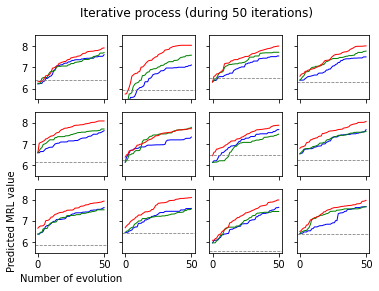

In [10]:
main()